# FLEX scRNA pilot
## Label transfer
- Author: Kane Foster
- Date: 26/March/2025

After QC and phenotyping, I am comparing the FLEX and matched 5' scRNA samples with published labels

In [1]:
import sys
import os
import math
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import numba
import scvi
import torch
import pynndescent
import torch; print(torch.cuda.is_available())

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/conda/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


True


In [ ]:
# HCLA 2023 paper
# https://www.nature.com/articles/s41591-023-02327-2
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty
    

## Data import

### Query prep

In [ ]:
adata_flex = sc.read('../out/single_cell_object/adata_clean.h5ad')

In [13]:
adata_flex.obs['tech'] = 'flex'
adata_flex.obs['study'] = 'df_flex'

In [14]:
adata_flex

AnnData object with n_obs × n_vars = 52759 × 18129
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'Scrublet_score', 'Scrublet_doublet', 'SCDS_cxds_score', 'SCDS_bcds_score', 'SCDS_hybrid_score', 'scDblFinder_score', 'scDblFinder_class', 'sample_id', 'retrieve_mt', 'tech', 'study'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [ ]:
adata_5prime = sc.read('../out/single_cell_object/adata_5prime_clean.h5ad')

In [15]:
adata_5prime.obs['tech'] = '5prime'
adata_5prime.obs['study'] = 'df_5prime'

In [ ]:
# Remove odd sample
adata_5prime = adata_5prime[adata_5prime.obs.sample_id!='pM10172_1_BM_CD138pos_GEX_5',]
# Downsample
sc.pp.sample(adata_5prime, fraction=0.4)

In [49]:
adata_5prime.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

### Reference prep

**Bandyopadhyay et al. 2024**, [GSE253355](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE253355).

In [ ]:
adata_Band = sc.read('../data/Bandyo/GSE253355_Normal_Bone_Marrow_Atlas_Seurat_SB_v2.h5ad')
adata_Band.write('../data/Bandyo/GSE253355_Normal_Bone_Marrow_Atlas_Seurat_SB_v2.h5ad',compression='gzip')
adata_Band = sc.read('../data/Bandyo/GSE253355_Normal_Bone_Marrow_Atlas_Seurat_SB_v2.h5ad')
adata_Band

In [ ]:
# Make equiv to scanpy adata

obs
var
var_names

### Data metadata and pooling

Metadata
* sample_id
* technology (FLEX or 5') - **batch covariate**
* study

In [17]:
# Merging
adatas=[ adata_flex, adata_5prime]
#adatas=[ adata_flex, adata_5prime, adata_Band ]
shared_obs = ['sample_id','tech','study']
#shared_var = [''] #!!!

from functools import reduce
shared_genes = reduce(np.intersect1d, [a.var_names for a in adatas])

adatas_processed = list()

for a in adatas:

    a = a[:,shared_genes].copy()
    adata = ad.AnnData(a.X, obs=a.obs[shared_obs], var=a.var[[]])
    adatas_processed.append(adata)

adata = ad.concat(
    adatas = adatas_processed,
    join='inner',
    merge='same',
    index_unique='-'
)
adata.var['gene'] = adata.var_names
adata

In [43]:
# HVGs
batch_key = 'tech'
##gene_gr_remove = [''] #!!!

dataHVG=adata.copy()
sc.pp.normalize_total(dataHVG, target_sum=1e4)
sc.pp.log1p(dataHVG) 

# Remove select gene groups
##for i in gene_gr_remove:
 ##   dataHVG = dataHVG[:, (dataHVG.var[i] != True)]

# Scanpy default HVG
sc.pp.highly_variable_genes(dataHVG, n_top_genes=3000, subset=True, batch_key=batch_key)
# Subset adata to HVG, use this for integration
adata_hvg = adata[:,dataHVG.var_names].copy()
adata.var['intHVG'] = adata.var['gene'].isin(dataHVG.var_names)
del dataHVG


In [63]:
adata_hvg

AnnData object with n_obs × n_vars = 125667 × 3000
    obs: 'sample_id', 'tech', 'study', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene', 'intHVG'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'tech_colors', 'sample_id_colors', 'leiden_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [62]:
pd.crosstab(adata_hvg.obs.sample_id,adata_hvg.obs.tech).head(10)

tech,5prime,flex
sample_id,,
BS-21-E23779,0,7201
BS-21-G52846,0,6066
BS-21-K19232,0,27136
BS-21-X68276,0,4028
BS-22-E02713,0,4145
BS-22-T49396,0,4183
NDM1066_1_PB_CD138pos_GEX_5,121,0
NDM1069_1_BM_CD138neg_GEX_5,2541,0
NDM1069_1_BM_CD138pos_GEX_5,6984,0


In [ ]:
# SCVI test

In [46]:
adata_hvg = adata[:,adata.var['intHVG']].copy()

In [47]:
# Settup AnnData object for scvi models.
scvi.model.SCVI.setup_anndata(
    adata_hvg, batch_key='tech', 
    categorical_covariate_keys=['sample_id'])

# Initialize scvi model 
scvi_model = scvi.model.SCVI(
    adata_hvg, n_latent=30, n_layers=2)

In [48]:
scvi_model.to_device('cuda:0') # moves model to GPU 0, cuda:0 just moves to the first available cuda 
scvi_model.train(400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [53]:
scvi_model.get_reconstruction_error()

{'reconstruction_loss': tensor(329.0173, device='cuda:0')}

In [50]:
adata_hvg.obsm["X_scVI"] = scvi_model.get_latent_representation()
sc.pp.neighbors(adata_hvg, use_rep="X_scVI", n_neighbors=10) 
sc.tl.umap(adata_hvg)
sc.tl.leiden(adata_hvg, resolution=0.5)

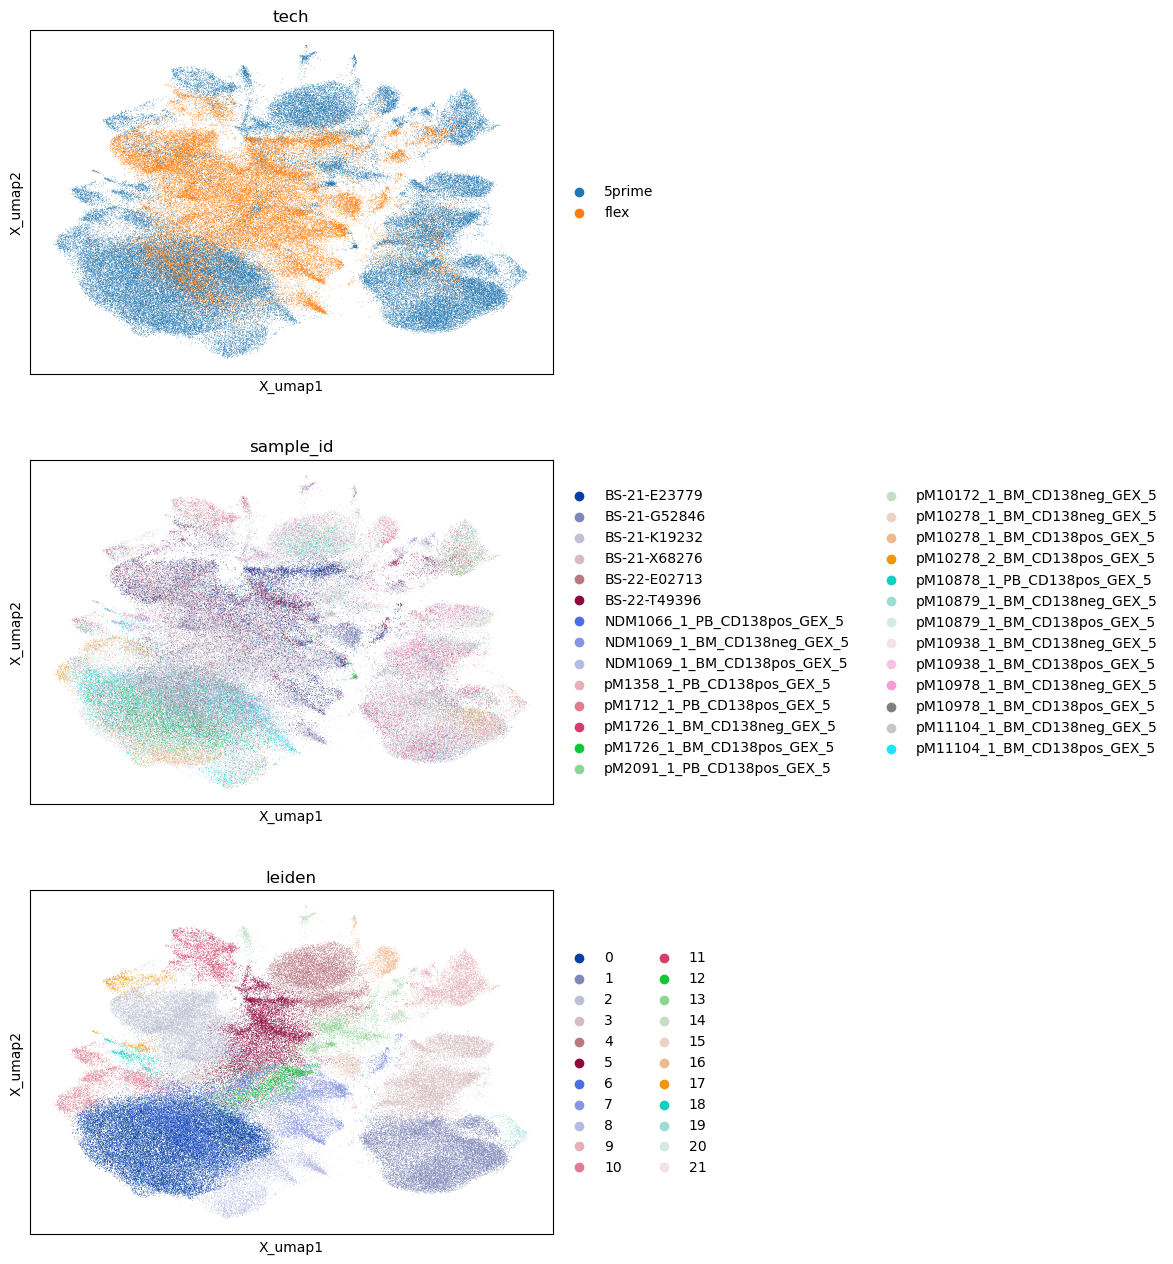

In [52]:
sc.pl.embedding(adata_hvg,basis='X_umap',
    color=['tech','sample_id','leiden'],
    size=1,ncols=1
)

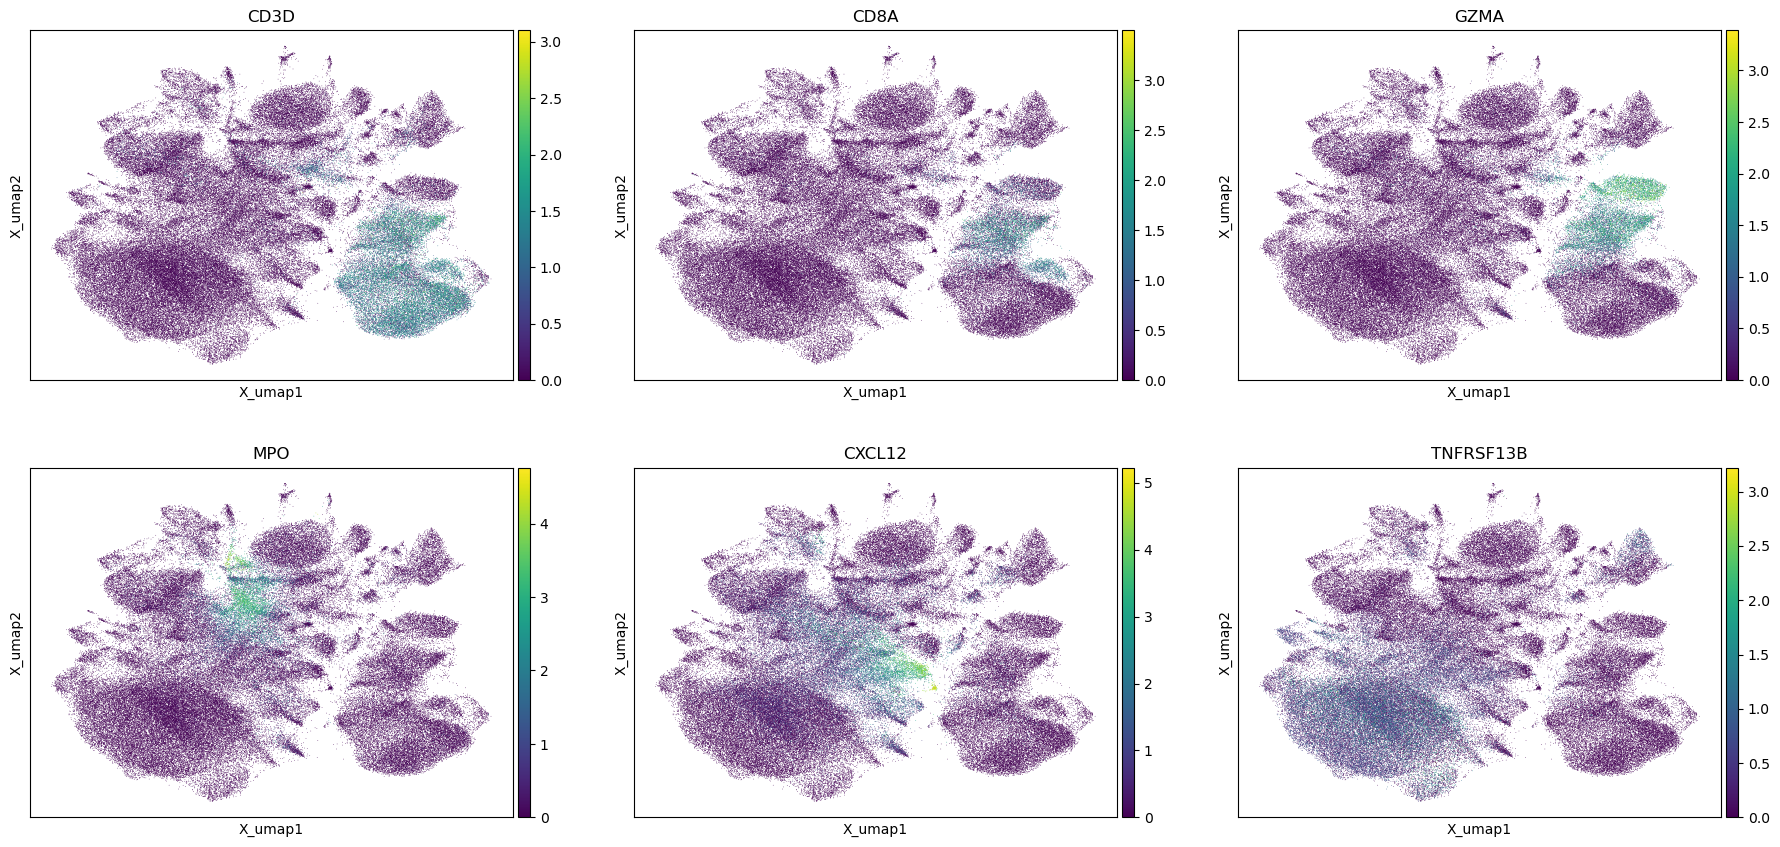

In [64]:
sc.pl.embedding(adata_hvg,basis='X_umap',
    color=['CD3D','CD8A','GZMA','MPO','CXCL12','TNFRSF13B'],
    size=1,ncols=3
)

## OG KF code

In [ ]:
# Import #######################################################################

adata_ref = sc.read(args.adata_ref_dir)
adata_ref = adata_ref[:,adata_ref.var['intHVG']]

model = scvi.model.SCVI.load(args.model_ref_dir, adata_ref.copy())
adata_query = sc.read(args.adata_query_dir)

In [ ]:
# scANVI model #################################################################

#Try to obtain a better latent representation/predictions by using the labels to inform 
#the latent space. This is where scANVI comes in. scANVI uses semi-supervised learning 
#to improve the model learned with scVI, allowing us to transfer our cell type knowledge
#from the reference to the query data.

# scANVI
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model, unlabeled_category='Unknown', labels_key='pheno', adata=adata_ref.copy())

scanvi_model.to_device('cuda:0') # moves model to GPU 0, cuda:0 just moves to the first available cuda 
scanvi_model.train(args.surgery_epochs) # similar n

# Learn a neighbors index on reference latent space
X_train = adata_ref.obsm["X_scVI"]
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

In [ ]:
# Build and train query model ##################################################

# Prep the reference for scvi
scvi.model.SCANVI.prepare_query_anndata(adata_query, scanvi_model)
adata_query.obs["scanvi_label"] = "unlabeled"

# Build model for query dataset using reference model
adata_query.obs['pheno'] = 'Unknown'
adata_query.obs['scanvi_label'] = 'Unknown'
query_model = scvi.model.SCANVI.load_query_data(adata_query, scanvi_model)

# Move to cuda GPU
query_model.to_device('cuda:0') # moves model to GPU 0, cuda:0 just moves to the first available cuda 

# scArches/scANVI-specific query training arguments.
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

# Train query model
query_model.train(max_epochs=args.surgery_epochs, **train_kwargs_surgery)

In [ ]:
# Query model output #############################################################

# Get latent representation of query model
query_emb = ad.AnnData(query_model.get_latent_representation())
query_emb.obs_names = adata_query.obs_names

# mde
from scvi.model.utils import mde
query_emb.obsm["X_mde"] = mde(query_emb.X)
query_emb.obs['X_mde1'] = query_emb.obsm['X_mde'][:,0]
query_emb.obs['X_mde2'] = query_emb.obsm['X_mde'][:,1]

# Nearest Neighbors Search of query within reference KNN
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)
#find the nearest neighbors (ref_neighbors) and their corresponding distances (ref_distances) 
#for each point in the query set (query_emb.X) based on a reference dataset. The ref_nn_index 
#seems to be a precomputed nearest neighbors index.

# Convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

# For each annotation level, get prediction and uncertainty
for l in args.label_keys:
    ref_cats = adata_ref.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata_ref.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

# Filter our predictions on the uncertainty threshold
#Using in the HLCA manuscript:
#uncertainty_threshold = 0.2
#Set higher for now, can edit later manually
uncertainty_threshold = 0.5
for l in args.label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > uncertainty_threshold
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

In [ ]:
# Save outputs ############################################################################
    
# Output
query_emb.obs.to_csv(f'~/Scratch/IntegratedBM/Surgery_output/{args.run_name}.csv')
adata_query.obs.to_csv(f'~/Scratch/IntegratedBM/Surgery_output/{args.run_name}-obs.csv')

## scvi test mini

In [36]:
# scvi mini test

adata = adata_5prime[:10000,adata_5prime.var.highly_variable]
adata.X = adata.layers['counts'].copy()
adata_hvg = adata.copy()
adata_hvg

AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample_id', 'retrieve_mt', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [37]:
scvi.model.SCVI.setup_anndata(adata_hvg, batch_key='sample_id')

In [38]:
scvi_model = scvi.model.SCVI(adata_hvg, n_latent=30, n_layers=2)

In [41]:
scvi_model.to_device('cuda:0') # moves model to GPU 0, cuda:0 just moves to the first available cuda 
scvi_model.train(10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [40]:
adata_hvg.obsm["X_scVI"] = scvi_model.get_latent_representation()
adata_hvg

AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample_id', 'retrieve_mt', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [43]:
scvi_model.get_reconstruction_error()

{'reconstruction_loss': tensor(93.6949, device='cuda:0')}